# (1) Introduction
This notebook will guide you through the journey of understanding Generative Adversarial Networks or (GANs) for short. However, before diving into this monster of a concept, we must understand the main concept between the GANs i.e, the main purpose of them. You can think of GANs as a  two-player [**minimax**](https://www.baeldung.com/java-minimax-algorithm) game where the generator (Generative) tries to fool the discriminator (the adversary) into thinking that what the generator is producing is indistinguishable from whatever real object we are trying to train the discriminator for. If you are unfamiliar with the concept of a minimax game, don't worry, we will cover it in the subsections to come. Now that we understand the main *purpose* of the GAN let's dive into it in more detail !!!

# (2) Importing the libraries
As when constructing any machine learning model, it is better to use libraries pre-built by other developers. In this section, as the title suggests, we are going to use [**PyTorch**](https://pytorch.org/). Why PyTorch? it's because as far as GANs are concerned I found this library easier for me to learn and implement. Below is the list of libraries I had used.

| Library      | Description |
| ----------- | ----------- |
| torch.nn      | Used to create the neural network       |
| torch.optim   | Used to create optimizers for neural network, in this section, we will be working with the [Adam](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31) optimizer.        |
| torchvision.datasets      | Used to upload the training dataset of  544. images of the marina and took 3.64 hours to train    |
| torch.transforms      | Used to transform the images into a more compatible format for the neural net       |
| Variable      | Used to create a tensor from an array or a variable      |


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import time as t

## (2a) Function to initialize the weights

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# (3) Generative Adversarial Networks (A Runthrough)

## (3a) Generator
The generator is an inverse [Convolutional Neural Network](https://github.com/codemasterady/Using-Convolutional-Neural-Networks-To-Predict-Pneumonia-In-Lungs/blob/main/Product_Manual.ipynb) which basically takes an input array or vector as input and generates an image of since (length, height, channel) where channel tells us if the image is coloured or black & white. As mentioned before, the generator takes an input vector. This vector is usually referred to as **noise** which is basically an array with randomised values fed into the network. As the Generator is yet to be trained when noise is passed through the network, it generates an image with random pixel values which makes the image look like that of (3ai). Training of the generator will be discussed down the road. As the generator is trained, and the weights updated, the noise array will be converted into more useful and meaningful images.


---

## (3ai) What noise looks like
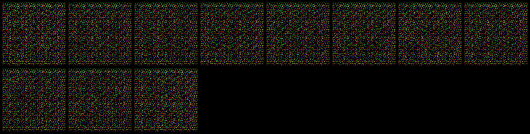


---
## (3aii) What the generator looks like
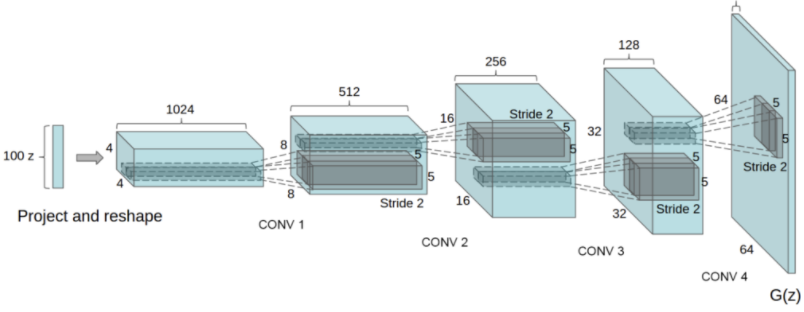


In [ ]:
class G(nn.Module): # We introduce a class to define the generator.

    def __init__(self): # We introduce the __init__() function that will define the architecture of the generator.
        super(G, self).__init__() # We inherit from the nn.Module tools.
        self.main = nn.Sequential( # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False), # We start with an inversed convolution.
            nn.BatchNorm2d(512), # We normalize all the features along the dimension of the batch.
            nn.ReLU(True), # We apply a ReLU rectification to break the linearity.
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(256), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(128), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(64), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.Tanh() # We apply a Tanh rectification to break the linearity and stay between -1 and +1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output containing the generated images.
        output = self.main(input) # We forward propagate the signal through the whole neural network of the generator defined by self.main.
        return output # We return the output containing the generated images.


The above code shows the basic way to construct a generator. This architecture consists  of  4 primary components

1. ConvTranspose Layer
2. BatchNorm Layer
3. ReLU Layer
4. Tanh Layer

The ConvTranspose layer constructs an image-like grid from an array.  For more information on the ConvTranspose layer, click [here](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). As all values in the neural network must be normalised, i.e between two sets of values (usually 0 - 1), to prevent any big differences in values between the pixels to affect the training of the model, [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) is used. ReLU is the activation function used in the hidden layers and the [Tanh](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6#:~:text=Tanh%20or%20hyperbolic%20tangent%20Activation%20Function&text=tanh%20is%20also%20sigmoidal%20(s,zero%20in%20the%20tanh%20graph.) is used in the last output layer to get the values of the pixels between 0 and 1. The **forward** function basically generates the output of the model given the input.

## (3b) The Discriminator
The discriminator is a neural net that takes images generated by the generator, and the real training images to train itself and try to predict if the fake, generated images are fake or real. Even if the discriminator resembles the classic Convolutional Neural Net, it's training procedure is not that straight forward. Ideally, the discriminator first trains itself with the **real, training images** first which follows a standard neural network backpropagation procedure. If you are unfamiliar with the concept, click [here](https://github.com/codemasterady/Phone-Price-Predictor/blob/main/About_The_Model.ipynb) to learn more. After going through **k** steps of training, the image from the generator is feed into the discriminator. The error of these two gets backpropagated into the generator. This is how the generator is trained using the feedback form the discriminator. Below is an image of a discriminator. If it looks familiar that's because it mimics a traditional convolutional neural net.


---

##(3bi)
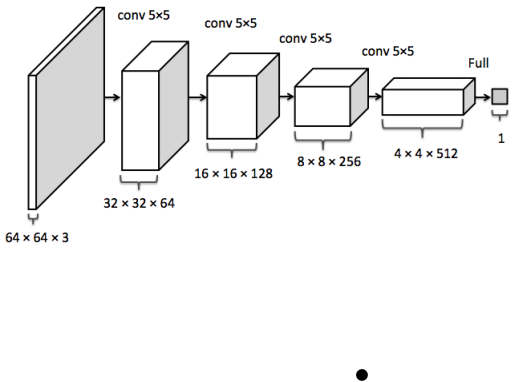

In [ ]:
class D(nn.Module): # We introduce a class to define the discriminator.

    def __init__(self): # We introduce the __init__() function that will define the architecture of the discriminator.
        super(D, self).__init__() # We inherit from the nn.Module tools.
        self.main = nn.Sequential( # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.Conv2d(3, 64, 4, 2, 1, bias = False), # We start with a convolution.
            nn.LeakyReLU(0.2, inplace = True), # We apply a LeakyReLU.
            nn.Conv2d(64, 128, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(128), # We normalize all the features along the dimension of the batch.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(256), # We normalize again.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(256, 512, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(512), # We normalize again.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(512, 1, 4, 1, 0, bias = False), # We add another convolution.
            nn.Sigmoid() # We apply a Sigmoid rectification to break the linearity and stay between 0 and 1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output which will be a value between 0 and 1.
        output = self.main(input) # We forward propagate the signal through the whole neural network of the discriminator defined by self.main.
        return output.view(-1) # We return the output which will be a value between 0 and 1.


## (3c) Other things we might need
Before we go on further discussing the workflow of the training process, let's take a look at some other important parameters we need for a successful GAN. Firstly, we must look at the type of **loss** used for backpropagation. We will be using the same well-known loss that we had been using for other projects. The well known **Binary Cross-Entropy Loss**. This is an obvious and optimal choice as the discriminator and the generator only had to choose between two states, *real* or *fake*. 

In [ ]:
criterion = nn.BCELoss()

Together with a loss, we must also define the optimizer for the algorithm. Therefore, as usual, we will be going with the stochastic gradient descent algorithm also commonly known as the **Adam**.

In [ ]:
# For the discriminator
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
# For the generator
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))

**NOTE**:

```
lr 
```
stands for learning rate. Also, we have a separate optimizer for the discriminator and the generator as they will be going through a separate training process.


# (4) Training
In this section, the training process will be briefly described. But before jumping into the steps, let's take a look at the overall view of the training process overflow.

1. Initializing the weights.
2. Training the discriminator with **real images**.
3. Training the discriminator with **fake images**.
4. Backpropagating the error to the discriminator.
5. Backpropagating the error to the generator.
6. Updating the weights of the generator.

Let's look at the steps in detail.

## (4a) Initializing the generator & discriminator

In [ ]:
# Generator
netG = G()
netG.apply(weights_init)

# Discriminator
netD = D()
netD.apply(weights_init)

## (4b) Initializing the weights

In [ ]:
netD.zero_grad()

## (4c) Training the discriminator with **real images**

### ***NOTE***:
The data variable represents the imported images.

### Steps

1. Get the data.
2. Convert the input image array into a PyTorch tensor.
3. Convert the **target** image array into a PyTorch tensor.
4. Get the output generated by the discriminator.
5. Calculate the loss between the input image and the discriminator output.

In [ ]:
real, _ = data
input = Variable(real)
target = Variable(torch.ones(input.size()[0]))
output = netD(input)
errD_real = criterion(output, target)

## (4d) Training the discriminator with **fake images**

### Steps

1. Generate an array with randomised values (A.K.A Noise).
2. Generate a fake image like the one at (4di).
3. **Generate** the target.
4. Create discriminator predictions.
4. Compute the loss between **prediction** and the **target**.


---

### 4di
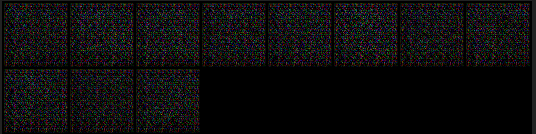



In [ ]:
noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
fake = netG(noise)
target = Variable(torch.zeros(input.size()[0]))
output = netD(fake.detach())
errD_fake = criterion(output, target)

## (4e) Backpropagating the error to the discriminator & generator

### Steps

1. Compute the total error **(real_image_error + fake_image_error)** for the discriminator.
2. Back propagate the error.
3. Apply the optimizer for the discriminator.

In [ ]:
errD = errD_real + errD_fake
errD.backward()
optimizerD.step()

## (4f) Updating the weights of the generator

### Steps

1. Initialize the gradients for the generator.
2. Create a PyTorch tensor of ones.
3. Get the fake images and pass them to the discriminator.
4. Back propagate the error.

In [ ]:
netG.zero_grad()
target = Variable(torch.ones(input.size()[0]))
output = netD(fake)
errG = criterion(output, target)
errG.backward()
optimizerG.step()

# (5) Saving the images through the epochs

In [ ]:
# Prints the results into the terminal
print(
  f"[{str(epoch)}/601][{str(i)}/{len(dataloader)}]")
# Saving the images
if (epoch  % 60 == 0):
fake = netG(noise)
vutils.save_image(
fake.data, f"Image of epoch {epoch}.png")

# (6) Image progression through the epochs.

---



## 0th Epoch
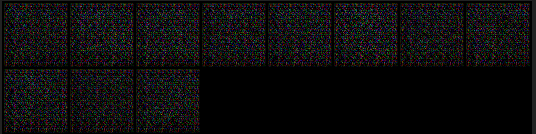

---



## 20th Epoch
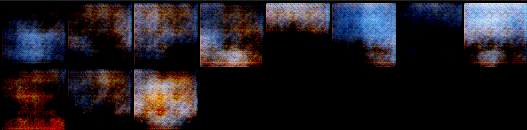

---



## 40th Epoch
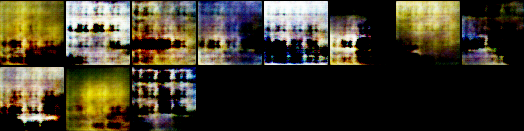

---



## 60th Epoch

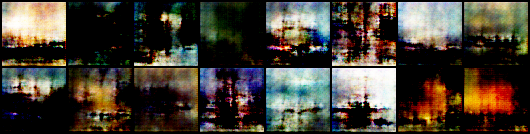

---



## 80th Epoch

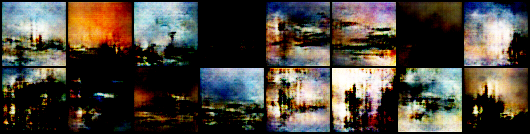

---



## 100th Epoch

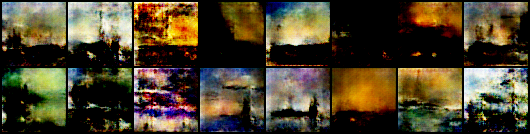

---



## 120th Epoch

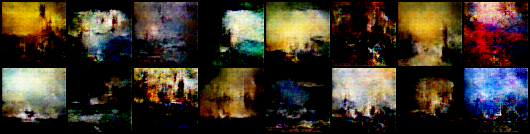


---



## 140th Epoch
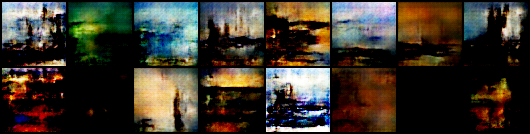



---



## 160th Epoch

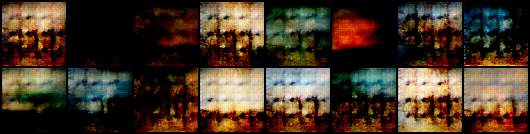


---



## 180th Epoch

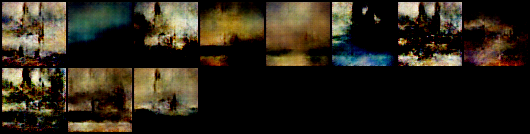


---



## 200th Epoch

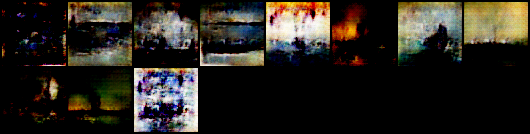


---



# (7) Conclusion
Viewing through all the images, it is obvious that the best results for the images were at epoch 100. And it is therefore observed that there is **overfitting occurring over epoch 100**. This overfitting is evident during the 160th epoch. The performance could be improved with a better model which will be updated later down the road. Feel free to clone and improve this algorithm.